In [51]:
import numpy as np
import matplotlib.pyplot as plt
from Optimizer.lib.utils import gen_quadratic_data, gen_criteria, OptPath
import copy
import torch
import matplotlib
import glob
import pandas as pd
from sklearn.externals import joblib
import tqdm
import seaborn as sns
from scipy.stats import ortho_group

# 1 (a) (b)

In [3]:
def drawContour(f, name, c='k', r=(-10,10), levels=None, alpha=1):
    a, b = r
    xlist = np.linspace(a, b, 100)
    ylist = np.linspace(a, b, 100)
    X, Y = np.meshgrid(xlist, ylist)
    cp = plt.contour(X, Y, f(X, Y), levels=levels, colors=c, alpha=alpha)
    plt.clabel(cp, inline=True, fontsize=10)
    #plt.title(name + ' Contour Plot', fontsize=15)
    plt.xlabel(r'$\theta_{0}$', fontsize=20)
    plt.ylabel(r'$\theta_{1}$', fontsize=20)

def Loss(criteria, *args, **kwargs): 
    def loss_(X, Y):
        x = torch.from_numpy(np.vstack([X.ravel(), Y.ravel()]).T).float()
        return criteria(x, *args, **kwargs).data.cpu().numpy().reshape(X.shape[0], X.shape[1])
    return loss_

def draw_path(opt_path, s=1, color=[1,0,1], name=None):
    path = opt_path.x_path
    if name is None:
        name = opt_path.opt.__class__.__name__.split('.')[-1]
    n = len(path)
    colors = np.ones((n, 1)).dot(np.array([color + [1]]))
    colors[:,3] = np.linspace(0.1, 1, n)
    plt.scatter(path[:, 0], path[:, 1], marker='s', s=s, c=colors, label=name)

def weight_decay(X, a, y, x0):
    return np.linalg.inv(X.T.dot(X) + a * np.eye(len(X.T))).dot(X.T.dot(y) + a * x0.reshape(-1, 1))


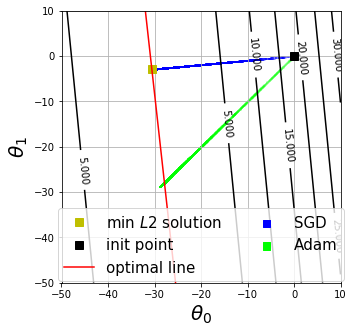

In [29]:
plt.gcf().set_size_inches(5, 5)
n = 300
d = 2
contour_ranges = None #[10, 20, 40, 80, 160, 320]
theta_star_0 = np.array([-30,-10]).reshape(-1,1)

Q = np.array([[-0.09509861,  0.99546786],
             [ 0.99546786,  0.09509861]]) #None #np.eye(d)
offset = 1
bs = 1
Q, Lambda, X, y = gen_quadratic_data(n=n, d=d, lambda_min=0, lambda_max=10, theta_star=theta_star_0, offset=offset, Q=Q)
criteria_o, theta_star_0 = gen_criteria(X, y)

X_ = X
y_ = y
criteria, theta_star = gen_criteria(X_, y_)
#drawContour(Loss(criteria, bs=10), "Loss", levels=contour_ranges, c='k', r=(-1, 1), alpha=1) #(-50, 10)
drawContour(Loss(criteria, bs=10), "Loss", levels=contour_ranges, c='k', r=(-50, 10), alpha=1) #(-50, 10)

######### optimization begins
opt_path = OptPath(max_iter=3000)

x0 = np.array([0, 0])
wds = [1e-10]
for wd in wds:
    x_wd = weight_decay(X_, wd, y_, x0)
    if wd == wds[-1]:
        plt.plot([x_wd[0]], [x_wd[1]], "s", color='y', markersize=8, label="min $L2$ solution")
    else:
        plt.plot([x_wd[0]], [x_wd[1]], "s", color='y', markersize=8)

plt.plot([x0[0]], [x0[1]], "s", color='k', markersize=8, label="init point")


opt_path.get_path(criteria, x0, lr=0.05, opt=torch.optim.SGD, bs=bs)
draw_path(opt_path, color=[0,0,1], s=2)

opt_path.get_path(criteria, x0, lr=0.1, opt=torch.optim.Adam, bs=bs)
draw_path(opt_path, color=[0,1,0], s=2)

# main drawing
k = (x_wd[1] - opt_path.x_path[-1][1]) / (x_wd[0] - opt_path.x_path[-1][0])
b = x_wd[1] -k * x_wd[0]
x = np.linspace(-50, 10)
plt.plot(x, k * x + b, color='r', label='optimal line')

plt.title(None)
plt.grid()
leg = plt.legend(markerscale=1, fontsize=15, ncol=2, loc='upper left', bbox_to_anchor=(-0.04, 0.3))
for lh in leg.legendHandles: 
    if type(lh) == matplotlib.collections.PathCollection:
        lh._sizes = [50]
    lh.set_alpha(1)
    
plt.xlim([-50, 10])
plt.ylim([-50, 10])

#plt.savefig('figures/1a.png', bbox_inches='tight')
plt.show()

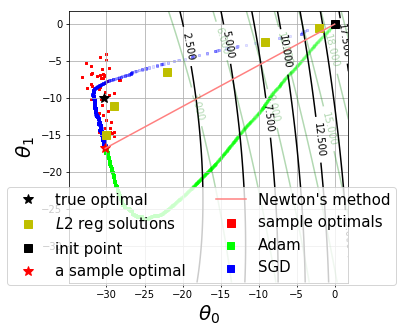

In [24]:
plt.gcf().set_size_inches(5, 5)
n = 300
d = 2
bs = 1
contour_ranges = None 
theta_star_0 = np.array([-30,-10]).reshape(-1,1)

Q = np.array([[-0.14146442,  0.98994334],
              [ 0.98994334,  0.14146442]])
#Q = None
offset = 0.5 # this actually is noise, the true theta_star is calculated below
Q, Lambda, X, y = gen_quadratic_data(n=n, d=d, lambda_min=1, lambda_max=10, theta_star=theta_star_0, offset=offset, Q=Q)
criteria_o, theta_star_0 = gen_criteria(X, y)
plt.plot([theta_star_0[0]], [theta_star_0[1]], '*', markersize=10, c='k', label='true optimal')

bs = 1
n_runs = 50 
longest_order = None
longest_dist = 0
for i in range(n_runs):
    order = np.random.permutation(len(X))[:10]
    X_ = X[order]
    y_ = y[order]
    criteria, theta_star = gen_criteria(X_, y_)
    if i == n_runs-1:
        plt.scatter([theta_star[0]], [theta_star[1]], marker='s', s=5, c='r', label='sample optimals')
    else:
        plt.scatter([theta_star[0]], [theta_star[1]], marker='s', s=5, c='r')
    dist = np.linalg.norm(theta_star - theta_star_0)
    if dist > longest_dist:
        longest_dist = dist
        longest_order = copy.deepcopy(order)

X_ = X[longest_order]
y_ = y[longest_order]
criteria_g, theta_star = gen_criteria(X_, y_)
#drawContour(Loss(criteria), "Loss", levels=contour_ranges, c='g', r=(theta_star_0[0][0]-30, theta_star_0[1][0]+30), alpha=0.3)

######### optimization begins
opt_path = OptPath(max_iter=5000)

x0 = np.array([0, 0])
wds = np.logspace(np.log10(0.005), np.log10(5), 5) #[0.005, 0.01, 0.05, 0.1, 0.5]
for wd in wds:
    x_wd = weight_decay(X_, wd, y_, x0)
    if wd == wds[-1]:
        plt.plot([x_wd[0]], [x_wd[1]], "s", color='y', markersize=8, label='$L2$ reg solutions')
    else:
        plt.plot([x_wd[0]], [x_wd[1]], "s", color='y', markersize=8)
        
plt.plot([x0[0]], [x0[1]], "s", color='k', markersize=8, label="init point")
plt.plot([theta_star[0]], [theta_star[1]], "*", color='r', markersize=10, label="a sample optimal")

opt_path.get_path(criteria_g, x0, lr=0.1, opt=torch.optim.Adam, bs=bs)
draw_path(opt_path, color=[0,1,0], s=5)

# opt_path.get_path(criteria, x0, lr=0.1, opt=optimizers.AdaSGD, bs=bs)
# draw_path(opt_path, color=[0,0,1], s=2)

opt_path.get_path(criteria_g, x0, lr=4/max(Lambda), opt=torch.optim.SGD, bs=bs)
draw_path(opt_path, color=[0,0,1], s=5)

# newton's method
plt.plot(np.linspace(theta_star[0], x0[0], 50), np.linspace(theta_star[1], x0[1], 50), 
         color=[1,0.5,0.5], label="Newton's method")

# main drawing
plt.title(None)
plt.grid()
leg = plt.legend(markerscale=1, fontsize=15, ncol=2, loc='upper left', bbox_to_anchor=(-0.25, 0.38))
for lh in leg.legendHandles: 
    if type(lh) == matplotlib.collections.PathCollection:
        lh._sizes = [50]
    lh.set_alpha(1)
        
drawContour(Loss(criteria_g, bs=10), "Loss", levels=contour_ranges, alpha=0.3, c='g', r=(min(plt.ylim()[0], plt.xlim()[0]), 
                                                                                max(plt.ylim()[1], plt.xlim()[1])))
drawContour(Loss(criteria_o, bs=n), "Loss", levels=contour_ranges, c='k', r=(min(plt.ylim()[0], plt.xlim()[0]), 
                                                                     max(plt.ylim()[1], plt.xlim()[1])))

#plt.savefig('figures/1b.png', bbox_inches='tight')
plt.show()

![lsr_loss1](figures/1a.png)
![lsr_loss5](figures/1b.png)

# 2 (a) (b) (c)

In [47]:
def get_record(savedirs=['result:0.1', 'result:0.01', 'result:0.001', 'result:1'], ):
    record = {'k': [], 'lambda_max': [], 'run_number': [], 'name': [], 'last_loss': [], 'lr': []}

    for folder in savedirs:
        for fn in tqdm.tqdm(glob.glob('synthetic_exp/{}/*'.format(folder))):
            name, k, lambda_max, run_number = list(map(lambda x: x[0](x[1]), zip([str, int, int, int], 
                                                                                 fn.split('/')[-1].split(':'))))
            record['name'].append(name)
            record['k'].append(k)
            record['lambda_max'].append(lambda_max)
            record['run_number'].append(run_number)
            f = joblib.load(fn)
            record['last_loss'].append(f['loss'][-1])
            record['lr'].append(f['lr'])
    return record

record = get_record(['result:0.1'])

100%|██████████| 3000/3000 [01:06<00:00, 44.96it/s]


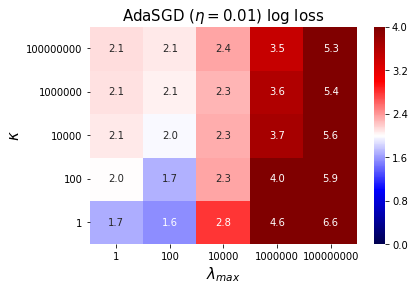

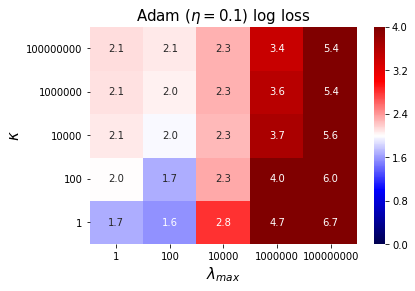

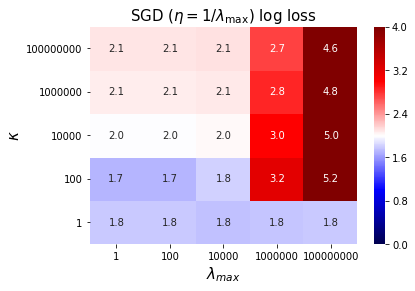

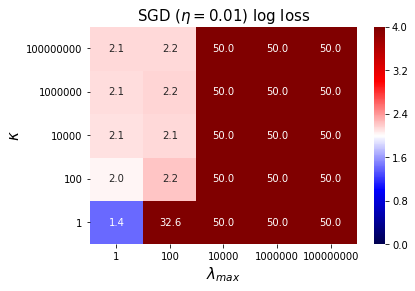

In [36]:
def generate_condition(df, lr):
    unwanted_lrs = set(np.unique(df.lr)) - set({lr})
    condition_lr = None
    for lr in unwanted_lrs:
        if condition_lr is None:
            condition_lr = (df.lr == lr)
        else:
            condition_lr = condition_lr | (df.lr == lr)
    
    condition_adam = (df.name == 'Adam')
    condition_sgd = (df.name == 'AdaSGD')
    return df[~( (condition_adam & condition_lr) | (condition_sgd & condition_lr))]

df = pd.DataFrame(record) 
#df = generate_condition(df, 0.01)
df = df.fillna(10**50)
df = df.groupby(['name', 'k', 'lambda_max'], as_index=False).mean()

for name in np.unique(df.name):
    content = df[df.name==name].pivot(index='k', columns='lambda_max', values='last_loss')
    #content.sortlevel(level=0, ascending=False, inplace=True)
    #content.sort_index(ascending=False)
    ax = sns.heatmap(np.log10(content + 1e-50), 
                #vmin=-10, vmax=10, cmap='seismic', annot=True, fmt=".0f")
                vmin=0, vmax=4, cmap='seismic', annot=True, fmt=".1f")
    ax.invert_yaxis()
    title = {
        'OptSGD': 'SGD ($\eta=1/\lambda_{\max}$)',
        'Adam': 'Adam ($\eta=0.1$)',
        'SGD': 'SGD ($\eta=0.01$)',
        'AdaSGD': 'AdaSGD ($\eta=0.01$)',
    }
    plt.title('{} log loss'.format(title[name]), fontsize=15)
    plt.ylabel('$\kappa$', fontsize=15)
    plt.xlabel('$\lambda_{max}$', fontsize=15)
    #plt.savefig('figures/{}_lambda_heatmap.png'.format(name), bbox_inches='tight')
    plt.show()

# 3 (b) 4 (a) (b)

/data1/jiaxuan/2019/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/data1/jiaxuan/2019/venv/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


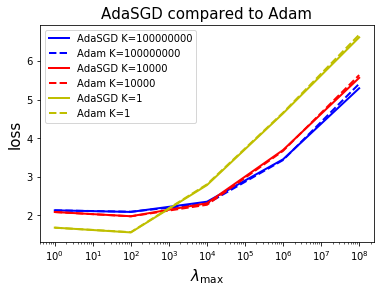

In [48]:
df = pd.DataFrame(record) 
#df = generate_condition(df, 0.01)
df = df.fillna(10**50)
df = df.groupby(['name', 'k', 'lambda_max'], as_index=False).mean()

k2color = {10**8: 'b', 10**4: 'r', 1: 'y'}

for k, c in k2color.items():
    A = df[df.name=='AdaSGD'][df.k==k]
    B = df[df.name=='Adam'][df.k==k]
    plt.semilogx(A.lambda_max, np.log10(A.last_loss + 1e-50), '-{}'.format(c), label='AdaSGD K={}'.format(k), 
                 linewidth=2)
    plt.semilogx(B.lambda_max, np.log10(B.last_loss + 1e-50), '--{}'.format(c), label='Adam K={}'.format(k),
                linewidth=2)
    
plt.legend()
plt.title('AdaSGD compared to Adam', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.xlabel(r'$\lambda_{\max}$', fontsize=15)
plt.savefig('figures/4a.png', bbox_inches='tight')
plt.show()

In [54]:
def get_record(savedirs=['angle_result']):
    record = {'k': [], 'lambda_max': [], 'run_number': [], 'name': [], 'last_loss': [], 'lr': [], 'angle': []}

    for folder in savedirs:
        for fn in tqdm.tqdm(glob.glob('synthetic_exp/{}/*'.format(folder))):
            name, k, lambda_max, run_number, angle = list(map(lambda x: x[0](x[1]), zip([str, int, int, int, float], 
                                                            fn.split('/')[-1].split(':'))))
            record['name'].append(name)
            record['k'].append(k)
            record['lambda_max'].append(lambda_max)
            record['run_number'].append(run_number)
            f = joblib.load(fn)
            record['last_loss'].append(f['loss'][-1])
            record['lr'].append(f['lr'])
            record['angle'].append(angle)
    return record

record = get_record()

100%|██████████| 3360/3360 [01:15<00:00, 44.66it/s]


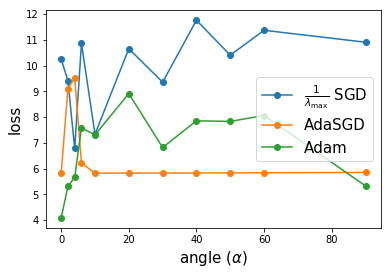

In [55]:
def generate_condition(df, angles):
    condition = None
    for a in angles:
        if condition is None: condition = (df.angle == a)
        else: condition = condition | (df.angle == a)
    return df[condition]

df = pd.DataFrame(record) 
df = df.fillna(10**50)
#df = generate_condition(df, np.linspace(0, 90, 10))
# df = generate_condition(df, #list(np.linspace(0, 1, 11)) + 
#                         [0,3,6,8,10,30,60,90])
#df = generate_condition(df, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60])
df = generate_condition(df, [0, 2, 4, 6, 10, 20, 30, 40, 50, 60, 90])

df = df[df.name != 'AdjustSGD']
df = df[df.name != 'SGD']
df = df.groupby(['name', 'k', 'lambda_max', 'angle'], as_index=False).mean()
df2 = df[df.name=='OptSGD']
df2.name = r'$\frac{1}{\lambda_{\max}}$ SGD'
df[df.name=='OptSGD'] = df2

for name in np.unique(df.name):
    s = df[df.name == name]
    plt.plot(s.angle, s.last_loss, '-o', label=name)
# sns.heatmap(np.log10(df.pivot(index='name', columns='angle', values='last_loss') + 1e-50), 
#             annot=True, fmt=".2f", vmin=0.5, vmax=1.1, cmap='seismic')
plt.ylabel('loss', fontsize=15)
plt.xlabel(r'angle ($\alpha$)', fontsize=15)
plt.legend(fontsize=15)
#plt.savefig('figures/3b.png', bbox_inches='tight')
plt.show()

In [52]:
collector = {}
for d in tqdm.tqdm(range(2,100)):
    collector[d] = []
    for _ in range(100):
        angle = np.arccos(np.abs(ortho_group.rvs(d)[0]).max()) / np.pi * 180
        collector[d].append(angle)


100%|██████████| 98/98 [00:24<00:00,  1.06it/s]


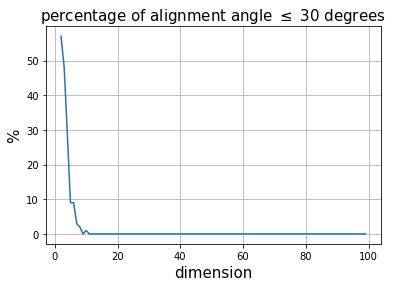

In [53]:
angle_threshold = 30
s = (pd.DataFrame(collector) <= angle_threshold).sum()
plt.plot(s.index, s)
plt.xlabel('dimension', fontsize=15)
plt.ylabel(r'%', fontsize=15)
plt.grid()
plt.title('percentage of alignment angle $\leq$ {} degrees'.format(angle_threshold), fontsize=15)
# plt.savefig('figures/4b.png')
plt.show()

The rest of the plots are in their respective folders! Next cell is a corrected version of figure 4b considering all other eigenvectors.

In [70]:
collector = {}
for d in tqdm.tqdm(range(2,100)): 
    collector[d] = []
    for _ in range(100):
        Q = ortho_group.rvs(d)
        for i in range(len(Q)):
            angle = np.arccos(np.abs(Q[i]).max()) / np.pi * 180
            collector[d].append(angle)

100%|██████████| 98/98 [00:26<00:00,  1.06s/it]


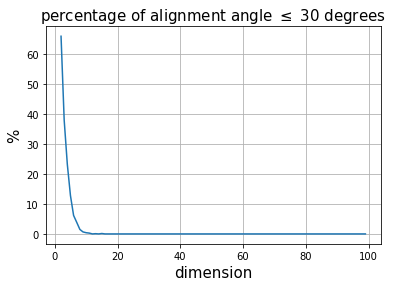

In [73]:
angle_threshold = 30
x = sorted(collector.keys())
y = []
for d in x:
    p_align = (np.array(collector[d]) <= angle_threshold).mean() * 100
    y.append(p_align)
    
plt.xlabel('dimension', fontsize=15)
plt.ylabel(r'%', fontsize=15)
plt.grid()
plt.title('percentage of alignment angle $\leq$ {} degrees'.format(angle_threshold), fontsize=15)
# plt.savefig('figures/4b.png')
plt.plot(x, y)
plt.show()

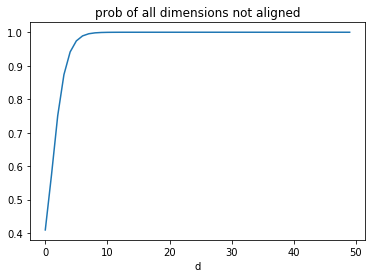

In [57]:
align_prob = 0.6
d = np.linspace(2, 100)
plt.plot((1-align_prob**d)**d)
plt.title('prob of all dimensions not aligned')
plt.xlabel('d')
plt.show()